In [1]:
import time
from math import sqrt
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt

In [2]:
import cv2
import os

def load_images_from_folder(folder):
    images = []
    filenames = []
    for filename in sorted(os.listdir(folder)):
        img = cv2.imread(os.path.join(folder,filename))
        RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if RGB_img is not None:
            images.append(RGB_img)
        filenames.append(filename)
    return images,filenames

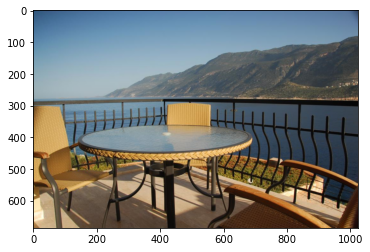

In [3]:
clean_img_folder = 'Sun_Hays_SR_groundtruth'
clean_imgs, clean_filenames = load_images_from_folder(clean_img_folder)
cnt = 0
plt.imshow(clean_imgs[3])
    

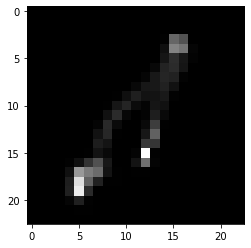

In [15]:
all_deblur_res_folder = 'all_deblur_results'
all_deblur_res, filenames = load_images_from_folder(all_deblur_res_folder)
# the kernels are placed at every third elmt within all_deblur_res 
kernel = all_deblur_res[-1]
plt.imshow(kernel)

In [6]:
filenames

['img10_groundtruth_img.png',
 'img10_kernel1_ChoAndLee_img_PSNR=22.4799_SSIM=0.7651.png',
 'img10_kernel1_ChoAndLee_kernel.png',
 'img10_kernel1_ChoEtAl_img_PSNR=21.0507_SSIM=0.64683.png',
 'img10_kernel1_ChoEtAl_kernel.png',
 'img10_kernel1_KrishnanEtAl2011_img_PSNR=20.6781_SSIM=0.69325.png',
 'img10_kernel1_KrishnanEtAl2011_kernel.png',
 'img10_kernel1_LevinEtAl2011_img_PSNR=20.5419_SSIM=0.69307.png',
 'img10_kernel1_LevinEtAl2011_kernel.png',
 'img10_kernel1_OurNat5x5_img_PSNR=26.1526_SSIM=0.81895.png',
 'img10_kernel1_OurNat5x5_kernel.png',
 'img10_kernel1_OurSynth5x5_img_PSNR=24.6016_SSIM=0.78655.png',
 'img10_kernel1_OurSynth5x5_kernel.png',
 'img10_kernel1_XuAndJia_img_PSNR=25.8957_SSIM=0.84713.png',
 'img10_kernel1_XuAndJia_kernel.png',
 'img10_kernel2_ChoAndLee_img_PSNR=25.6974_SSIM=0.83025.png',
 'img10_kernel2_ChoAndLee_kernel.png',
 'img10_kernel2_ChoEtAl_img_PSNR=21.5466_SSIM=0.59396.png',
 'img10_kernel2_ChoEtAl_kernel.png',
 'img10_kernel2_KrishnanEtAl2011_img_PSNR=19.9

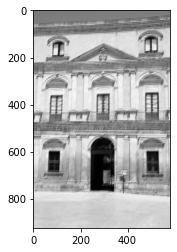

In [18]:
kernel = all_deblur_res[3]
plt.imshow(kernel)

In [7]:
from PIL import Image
import cv2

def synthetic_blur(k, xs, sigma):
    blurred_imgs = []
    for x in xs:
        # blurring the image
        img_numpy = np.asarray(x).astype(float)
        
        (iH, iW) = img_numpy.shape[:2]
        (kH, kW) = kernel.shape[:2]
        pad = (kW - 1) // 2
        image = cv2.copyMakeBorder(img_numpy, pad, pad, pad, pad, cv2.BORDER_REPLICATE)
        output = np.zeros((iH, iW), dtype="float32")
        n = np.random.randn(*img_numpy.shape)
        
        for y in np.arange(pad, iH + pad):
            for x in np.arange(pad, iW + pad):
                # extract the region of interest
                roi = image[y - pad:y + pad + 1, x - pad:x + pad + 1]
                k = (roi * kernel)
                
                output[y - pad, x - pad] = k
        
        output += float(sigma) * n
        
        blurred_img = np.clip(output, 0, 255).astype(np.uint8)
        blurred_img = Image.fromarray(blurred_img, mode='RGB')
        
        blurred_imgs.append(blurred_img)
        break
    
    return blurred_imgs

In [4]:
def soft_thresh(x, l):
    return np.sign(x) * np.maximum(np.abs(x) - l, 0.)


def ista(A, b, l, maxit):
    x = np.zeros(A.shape[1])
    pobj = []
    L = linalg.norm(A) ** 2  # Lipschitz constant
    time0 = time.time()
    for _ in range(maxit):
        x = soft_thresh(x + np.dot(A.T, b - A.dot(x)) / L, l / L)
        this_pobj = 0.5 * linalg.norm(A.dot(x) - b) ** 2 + l * linalg.norm(x, 1)
        pobj.append((time.time() - time0, this_pobj))

    times, pobj = map(np.array, zip(*pobj))
    return x, pobj, times

def fista(A, b, l, maxit):
    x = np.zeros(A.shape[1])
    pobj = []
    t = 1
    z = x.copy()
    L = linalg.norm(A) ** 2
    time0 = time.time()
    for _ in range(maxit):
        xold = x.copy()
        z = z + A.T.dot(b - A.dot(z)) / L
        x = soft_thresh(z, l / L)
        t0 = t
        t = (1. + sqrt(1. + 4. * t ** 2)) / 2.
        z = x + ((t0 - 1.) / t) * (x - xold)
        this_pobj = 0.5 * linalg.norm(A.dot(x) - b) ** 2 + l * linalg.norm(x, 1)
        pobj.append((time.time() - time0, this_pobj))

    times, pobj = map(np.array, zip(*pobj))
    return x, pobj, times

In [5]:
rng = np.random.RandomState(42)
m, n = 15, 20

# random matrix A
A = rng.randn(m, n)  

x0 = rng.rand(n)
x0[x0 < 0.9] = 0
print('original x: {}'.format(x0))
b = np.dot(A, x0)
l = 0.5  # regularization parameter
print(x0)
maxit = 3000
x_ista, pobj_ista, times_ista = ista(A, b, l, maxit)
print('x ISTA: {}'.format(x_ista))
x_fista, pobj_fista, times_fista = fista(A, b, l, maxit)
print('x  FISTA: {}'.format(x_fista))
plt.close('all')


original x: [0.         0.         0.         0.         0.99050514 0.
 0.         0.         0.         0.93075733 0.         0.
 0.         0.         0.         0.90255291 0.         0.
 0.         0.        ]
[0.         0.         0.         0.         0.99050514 0.
 0.         0.         0.         0.93075733 0.         0.
 0.         0.         0.         0.90255291 0.         0.
 0.         0.        ]
x ISTA: [-0.          0.          0.         -0.          0.93564589  0.
  0.          0.          0.          0.89123484  0.         -0.
 -0.          0.         -0.          0.85442069 -0.          0.
  0.         -0.        ]
x  FISTA: [-0.          0.          0.         -0.          0.93564589  0.
  0.          0.          0.          0.89123484  0.         -0.
 -0.          0.         -0.          0.85442069 -0.          0.
  0.         -0.        ]


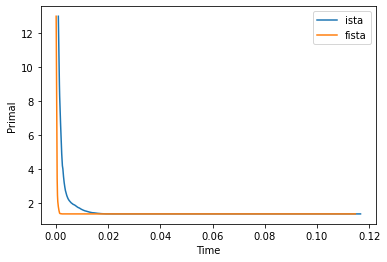

In [6]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(times_ista, pobj_ista, label='ista')
plt.plot(times_fista, pobj_fista, label='fista')
plt.xlabel('Time')
plt.ylabel('Primal')
plt.legend()
plt.show()